Buses to regions

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


Number of buses in the PyPSA network: 190
GADM Columns: Index(['GADM_ID', 'country', 'NAME_1', 'pop', 'gdp', 'geometry'], dtype='object')
  Bus  v_nom tag_substation  tag_area      lon     lat country        x  \
0   1  380.0   transmission       0.0  39.2077 -6.7933      TZ  39.2077   
1   3  380.0   transmission       0.0  32.9670 -2.5430      TZ  32.9670   
2   5  380.0   transmission       0.0  37.6638 -6.7988      TZ  37.6638   
3   6  380.0   transmission       0.0  33.4967 -8.9146      TZ  33.4967   
4   8  380.0   transmission       0.0  36.7110 -3.4156      TZ  36.7110   

        y control generator carrier type unit  v_mag_pu_set  v_mag_pu_min  \
0 -6.7933      PQ                AC                     1.0           0.0   
1 -2.5430      PQ                AC                     1.0           0.0   
2 -6.7988      PQ                AC                     1.0           0.0   
3 -8.9146      PQ                AC                     1.0           0.0   
4 -3.4156      PQ         

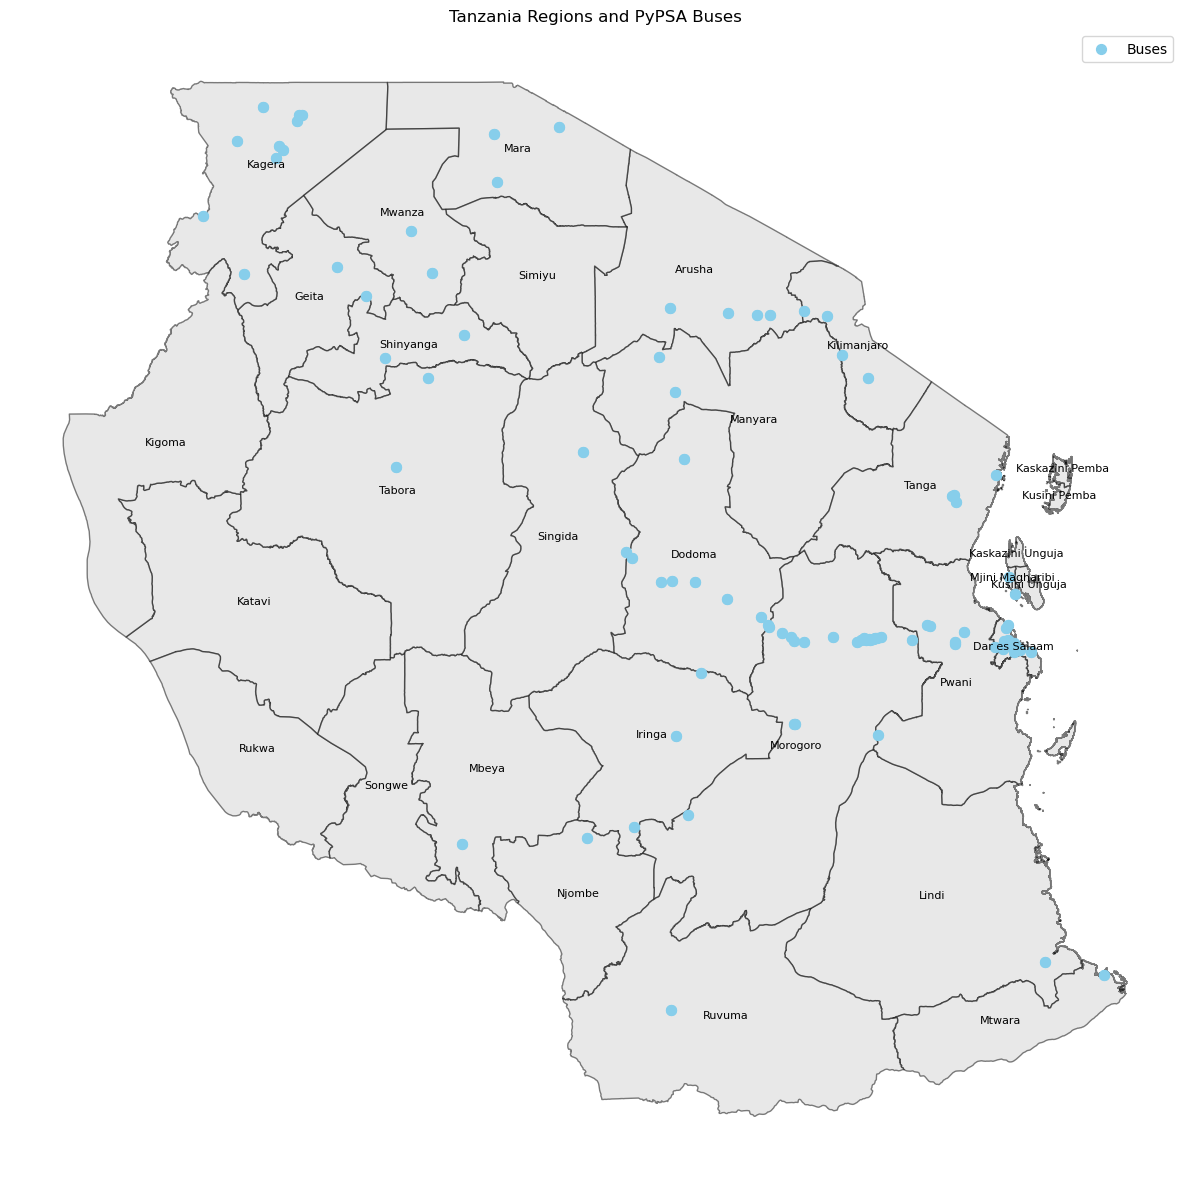

In [26]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pypsa

# Load the PyPSA network
model = pypsa.Network('C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec_s_all_ec_lcopt_1h.nc')
# Number of buses in the network
print(f"Number of buses in the PyPSA network: {len(model.buses)}")

# Load GADM shapefile
gadm_path = "C:/Users/hie/pe_tan/pypsa-earth/resources/shapes/gadm_shapes.geojson"   
gadm = gpd.read_file(gadm_path)

# Print columns in the GADM file
print("GADM Columns:", gadm.columns)

# Ensure valid geometries in GADM
if not gadm.is_valid.all():
    gadm = gadm.buffer(0)

# Load PyPSA buses
# Reset the index to include bus identifiers as a column
buses = model.buses.reset_index()  # Reset the index to include bus identifiers
buses.rename(columns={"index": "Bus"}, inplace=True)  # Rename the index column to "Bus"

# Create geometry from coordinates
buses["geometry"] = gpd.points_from_xy(buses["x"], buses["y"])
buses_gdf = gpd.GeoDataFrame(buses, geometry="geometry", crs=gadm.crs)  # Ensure CRS matches GADM
print(buses_gdf.head())

# Ensure valid geometries in buses
if not buses_gdf.is_valid.all():
    buses_gdf = buses_gdf.buffer(0)

# Reproject GADM to match buses CRS if necessary
if gadm.crs != buses_gdf.crs:
    gadm = gadm.to_crs(buses_gdf.crs)

# Perform spatial join to determine which bus falls under which region
buses_with_regions = gpd.sjoin(buses_gdf, gadm, how="left", predicate="intersects")

# Extract relevant columns, including the bus number
buses_with_regions = buses_with_regions[["Bus", "geometry", "NAME_1"]] 

# Rename columns for clarity
buses_with_regions.rename(columns={"NAME_1": "Region"}, inplace=True)

# Display the result
print(buses_with_regions.head())

# Save to a CSV file for further analysis
buses_with_regions.to_csv("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/buses_with_regions.csv", index=False)

# Plot the buses and regions
fig, ax = plt.subplots(figsize=(12, 12))
gadm.plot(ax=ax, edgecolor="black", facecolor="lightgray", alpha=0.5)
buses_with_regions.plot(ax=ax, color="skyblue", markersize=50, label="Buses")

# Annotate region names
for _, row in gadm.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row["NAME_1"], fontsize=8, ha='center', color='black')



plt.title("Tanzania Regions and PyPSA Buses")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()


Match custom power plant with bus and region

In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# Load the buses with regions data
buses_with_regions_path = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/buses_with_regions.csv"
buses_with_regions = pd.read_csv(buses_with_regions_path, delimiter=",")

# Convert buses_with_regions to a GeoDataFrame
buses_with_regions["geometry"] = gpd.GeoSeries.from_wkt(buses_with_regions["geometry"])
buses_gdf = gpd.GeoDataFrame(buses_with_regions, geometry="geometry", crs="EPSG:4326")

# Load the power plants data
power_plants_path = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom_powerplants.csv"
power_plants = pd.read_csv(power_plants_path,delimiter=";")

# Debug: Print column names to verify
print("Power plants columns:", power_plants.columns)

# Check if 'lon' and 'lat' columns exist
if "lon" not in power_plants.columns or "lat" not in power_plants.columns:
    raise KeyError("The 'lon' and/or 'lat' columns are missing in the power plants data.")

# Convert power plants to a GeoDataFrame
power_plants["geometry"] = gpd.points_from_xy(power_plants["lon"], power_plants["lat"])
power_plants_gdf = gpd.GeoDataFrame(power_plants, geometry="geometry", crs="EPSG:4326")

# Re-project both GeoDataFrames to a projected CRS (e.g., EPSG:3857 for meters)
buses_gdf = buses_gdf.to_crs("EPSG:3857")
power_plants_gdf = power_plants_gdf.to_crs("EPSG:3857")

# Perform a spatial join to match power plants with the nearest bus
power_plants_with_buses = gpd.sjoin_nearest(
    power_plants_gdf, buses_gdf, how="left", distance_col="distance_to_bus"
)

# Load the GADM shapefile for regions
gadm_path = "C:/Users/hie/pe_tan/pypsa-earth/resources/shapes/gadm_shapes.geojson"
gadm = gpd.read_file(gadm_path)

# Re-project GADM to the same projected CRS
gadm = gadm.to_crs("EPSG:3857")

# Perform a spatial join to match power plants with regions
power_plants_with_regions = gpd.sjoin(
    power_plants_with_buses, gadm, how="left", predicate="intersects", rsuffix="_region"
)

# Extract relevant columns
power_plants_with_regions = power_plants_with_regions[
    ["Name", "Technology", "lat", "lon", "Bus", "Region", "distance_to_bus"]
]

# Save the result to a CSV file
output_path = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/power_plants_with_buses_and_regions.csv"
power_plants_with_regions.to_csv(output_path, index=False)

# Display the result
print(power_plants_with_regions.head())

Power plants columns: Index(['id', 'Name', 'Fueltype', 'Technology', 'Set', 'Country', 'Capacity',
       'Efficiency', 'Duration', 'Volume_Mm3', 'DamHeight_m',
       'StorageCapacity_MWh', 'DateIn', 'DateRetrofit', 'DateOut', 'lat',
       'lon', 'EIC', 'projectID', 'bus'],
      dtype='object')
      Name    Technology     lat      lon         Bus    Region  \
0   Kidatu     Reservoir -7.6367  36.8866  61 battery  Morogoro   
0   Kidatu     Reservoir -7.6367  36.8866          61  Morogoro   
1  Kihansi  Run-Of-River -8.5751  35.8512  20 battery  Morogoro   
1  Kihansi  Run-Of-River -8.5751  35.8512          20  Morogoro   
2    Mtera     Reservoir -7.1386  35.9888  14 battery    Iringa   

   distance_to_bus  
0      9471.000912  
0      9471.000912  
1      4303.770523  
1      4303.770523  
2        45.919372  
